In [232]:
%matplotlib inline

import os
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal, stats
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.statespace.sarimax import SARIMAX

## some datetime conversion warning
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Always make it pretty.
plt.style.use('ggplot')

In [233]:
clinical_lab_df = pd.read_csv("/Users/GuntherUlvanget/Capstone/Capstone2/Influenza/stateFluViewPhase2Data 2/WHO_NREVSS_Clinical_Labs.csv",header = 1, na_values = 'X', na_filter = True)

In [234]:
#not all states report weekly public health data. convert the X to na and drop

clinical_lab_df.dropna(axis = 0, inplace = True)
clinical_lab_df.head()

,REGION TYPE,REGION,YEAR,WEEK,TOTAL SPECIMENS,TOTAL A,TOTAL B,PERCENT POSITIVE,PERCENT A,PERCENT B
0,States,Alabama,2015,40,167.0,2.0,3.0,2.99,1.20,1.80
2,States,Arizona,2015,40,55.0,0.0,0.0,0.00,0.00,0.00
3,States,Arkansas,2015,40,26.0,0.0,1.0,3.85,0.00,3.85
4,States,California,2015,40,683.0,2.0,0.0,0.29,0.29,0.00
5,States,Colorado,2015,40,255.0,0.0,1.0,0.39,0.00,0.39


In [235]:
clinical_lab_df["date"] = pd.to_datetime(clinical_lab_df.YEAR.astype(str), format='%Y') + \
             pd.to_timedelta(clinical_lab_df.WEEK.mul(7).astype(str) + ' days')

In [236]:
clinical_lab_df.drop(columns = ["REGION TYPE","YEAR","WEEK", "PERCENT POSITIVE", "PERCENT A","PERCENT B"], inplace = True)
clinical_lab_df.head()

,REGION,TOTAL SPECIMENS,TOTAL A,TOTAL B,date
0,Alabama,167.0,2.0,3.0,2015-10-08
2,Arizona,55.0,0.0,0.0,2015-10-08
3,Arkansas,26.0,0.0,1.0,2015-10-08
4,California,683.0,2.0,0.0,2015-10-08
5,Colorado,255.0,0.0,1.0,2015-10-08


In [237]:
public_health_lad_df = pd.read_csv("/Users/GuntherUlvanget/Capstone/Capstone2/Influenza/stateFluViewPhase2Data 2/WHO_NREVSS_Public_Health_Labs.csv", header = 1, na_values = 'X', na_filter = True)
public_health_lad_df.dropna(axis = 0, inplace = True)

In [238]:
public_health_lad_df.head()

,REGION TYPE,REGION,SEASON_DESCRIPTION,TOTAL SPECIMENS,A (2009 H1N1),A (H3),A (Subtyping not Performed),B,BVic,BYam,H3N2v
0,States,Alabama,Season 2015-16,256.0,59.0,16.0,1.0,2.0,2.0,2.0,0.0
1,States,Alaska,Season 2015-16,4691.0,607.0,98.0,0.0,231.0,1.0,2.0,0.0
2,States,Arizona,Season 2015-16,2110.0,762.0,580.0,0.0,13.0,58.0,399.0,0.0
3,States,Arkansas,Season 2015-16,128.0,20.0,8.0,0.0,1.0,12.0,0.0,0.0
4,States,California,Season 2015-16,12820.0,1462.0,854.0,35.0,775.0,309.0,803.0,0.0


In [239]:
type(public_health_lad_df["SEASON_DESCRIPTION"][0])

public_health_lad_df["SEASON_DESCRIPTION"] = public_health_lad_df["SEASON_DESCRIPTION"].map(lambda x: x.lstrip('Season '))

In [240]:
#pd.to_datetime(public_health_lad_df.SEASON_DESCRIPTION.astype(str), format='%Y%w%d')
public_health_lad_df[['YEAR','WEEK']] = public_health_lad_df.SEASON_DESCRIPTION.str.split("-",expand=True)

In [241]:
public_health_lad_df['YEAR'] = pd.to_numeric(public_health_lad_df['YEAR'] )
public_health_lad_df['WEEK'] = pd.to_numeric(public_health_lad_df['WEEK'] )

In [245]:
public_health_lad_df["date"] = pd.to_datetime(public_health_lad_df.YEAR.astype(str), format='%Y') + \
             pd.to_timedelta(public_health_lad_df.WEEK.mul(7).astype(str) + ' days')
public_health_lad_df.head()

,REGION TYPE,REGION,SEASON_DESCRIPTION,TOTAL SPECIMENS,A (2009 H1N1),A (H3),A (Subtyping not Performed),B,BVic,BYam,H3N2v,YEAR,WEEK,date,TOTAL A,TOTAL B
0,States,Alabama,2015-16,256.0,59.0,16.0,1.0,2.0,2.0,2.0,0.0,2015,16,2015-04-23,76.0,6.0
1,States,Alaska,2015-16,4691.0,607.0,98.0,0.0,231.0,1.0,2.0,0.0,2015,16,2015-04-23,705.0,234.0
2,States,Arizona,2015-16,2110.0,762.0,580.0,0.0,13.0,58.0,399.0,0.0,2015,16,2015-04-23,1342.0,470.0
3,States,Arkansas,2015-16,128.0,20.0,8.0,0.0,1.0,12.0,0.0,0.0,2015,16,2015-04-23,28.0,13.0
4,States,California,2015-16,12820.0,1462.0,854.0,35.0,775.0,309.0,803.0,0.0,2015,16,2015-04-23,2351.0,1887.0


In [246]:

public_health_lad_df["TOTAL A"]= pd.to_numeric(public_health_lad_df["A (2009 H1N1)"])+pd.to_numeric(public_health_lad_df["A (H3)"])+pd.to_numeric(public_health_lad_df["A (Subtyping not Performed)"]) 
public_health_lad_df["TOTAL B"]= pd.to_numeric(public_health_lad_df["BVic"])+pd.to_numeric(public_health_lad_df["BYam"])+pd.to_numeric(public_health_lad_df["H3N2v"]) +pd.to_numeric(public_health_lad_df["B"])
public_health_lad_df.drop(columns= ["REGION TYPE","A (2009 H1N1)", "SEASON_DESCRIPTION","A (H3)" ,"H3N2v", "BYam", "BVic","B","A (Subtyping not Performed)","YEAR","WEEK"], inplace = True)
public_health_lad_df.head()

,REGION,TOTAL SPECIMENS,date,TOTAL A,TOTAL B
0,Alabama,256.0,2015-04-23,76.0,6.0
1,Alaska,4691.0,2015-04-23,705.0,234.0
2,Arizona,2110.0,2015-04-23,1342.0,470.0
3,Arkansas,128.0,2015-04-23,28.0,13.0
4,California,12820.0,2015-04-23,2351.0,1887.0


In [247]:
combined_labs_pre_2015_df = pd.read_csv("/Users/GuntherUlvanget/Capstone/Capstone2/Influenza/stateFluViewPhase2Data 2/WHO_NREVSS_Combined_prior_to_2015_16.csv",  header = 1, na_values = 'X', na_filter = True)

combined_labs_pre_2015_df.dropna(axis = 0, inplace = True)
combined_labs_pre_2015_df.head()

,REGION TYPE,REGION,YEAR,WEEK,TOTAL SPECIMENS,PERCENT POSITIVE,A (2009 H1N1),A (H1),A (H3),A (Subtyping not Performed),A (Unable to Subtype),B,H3N2v
0,States,Alabama,2010,40,54.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,States,Alaska,2010,40,40.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,States,Arizona,2010,40,40.0,2.50,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,States,Arkansas,2010,40,15.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,States,California,2010,40,183.0,3.28,2.0,0.0,3.0,0.0,0.0,1.0,0.0


In [248]:
combined_labs_pre_2015_df["TOTAL A"]= pd.to_numeric(combined_labs_pre_2015_df["A (2009 H1N1)"]) + pd.to_numeric(combined_labs_pre_2015_df["A (H3)"]) + pd.to_numeric(combined_labs_pre_2015_df["A (Subtyping not Performed)"]) + pd.to_numeric(combined_labs_pre_2015_df["A (Unable to Subtype)"])+ pd.to_numeric(combined_labs_pre_2015_df ["A (H1)"]) 

In [249]:
combined_labs_pre_2015_df["TOTAL B"]= pd.to_numeric(combined_labs_pre_2015_df["H3N2v"]) +  pd.to_numeric(combined_labs_pre_2015_df["B"])

In [250]:
combined_labs_pre_2015_df["date"] =  pd.to_datetime(combined_labs_pre_2015_df.YEAR.astype(str), format='%Y') + \
             pd.to_timedelta(combined_labs_pre_2015_df.WEEK.mul(7).astype(str) + ' days')

In [251]:
combined_labs_pre_2015_df.drop(columns= ["REGION TYPE","A (2009 H1N1)", "A (H3)" ,"H3N2v",  "B","A (Subtyping not Performed)","YEAR","WEEK", "PERCENT POSITIVE", "A (H1)",  "A (Unable to Subtype)"], inplace = True)
combined_labs_pre_2015_df.head()

,REGION,TOTAL SPECIMENS,TOTAL A,TOTAL B,date
0,Alabama,54.0,0.0,0.0,2010-10-08
1,Alaska,40.0,0.0,0.0,2010-10-08
2,Arizona,40.0,1.0,0.0,2010-10-08
3,Arkansas,15.0,0.0,0.0,2010-10-08
4,California,183.0,5.0,1.0,2010-10-08


In [252]:
ten_year_influenza_confirmed = pd.concat([combined_labs_pre_2015_df,public_health_lad_df,clinical_lab_df], sort=False)

In [275]:

ten_year_influenza_confirmed['Confirmed_Infections'] = ten_year_influenza_confirmed["TOTAL A"] + ten_year_influenza_confirmed["TOTAL B"]
total_infections =ten_year_influenza_confirmed.groupby(["date"]).sum()

total_infections.reset_index(inplace=True)
total_infections.head()

,date,TOTAL SPECIMENS,TOTAL A,TOTAL B,Confirmed_Infections
0,2010-10-08,3200.0,36.0,9.0,45.0
1,2010-10-15,3501.0,49.0,18.0,67.0
2,2010-10-22,3572.0,39.0,23.0,62.0
3,2010-10-29,3702.0,65.0,23.0,88.0
4,2010-11-05,4028.0,77.0,57.0,134.0


[]

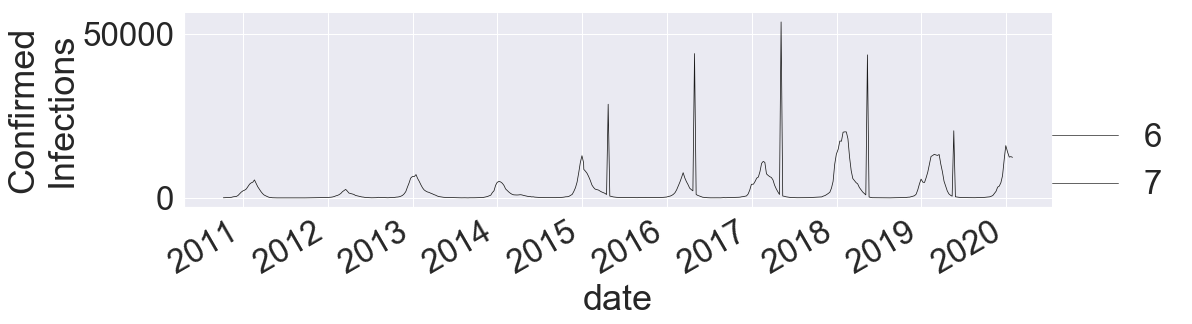

In [285]:
# the following states have higher morbidity rates due to influenza than the nations averag of 13.5 per 100,000. We will examin them first
states_of_interest=["Hawaii"," Mississippi", "Tennessee","New York","Nevada","Kentucky","West Virginia","Alabama", "Arkansas"] 


mask_list = [ten_year_influenza_confirmed["REGION"] == state for state in states_of_interest] 

g = sns.relplot(x="date", y="Confirmed_Infections",  kind="line", data=total_infections, size=7, aspect=3,color = "k" )
g.fig.autofmt_xdate()
plt.ylabel("Confirmed\nInfections") 
plt.plot()

[]

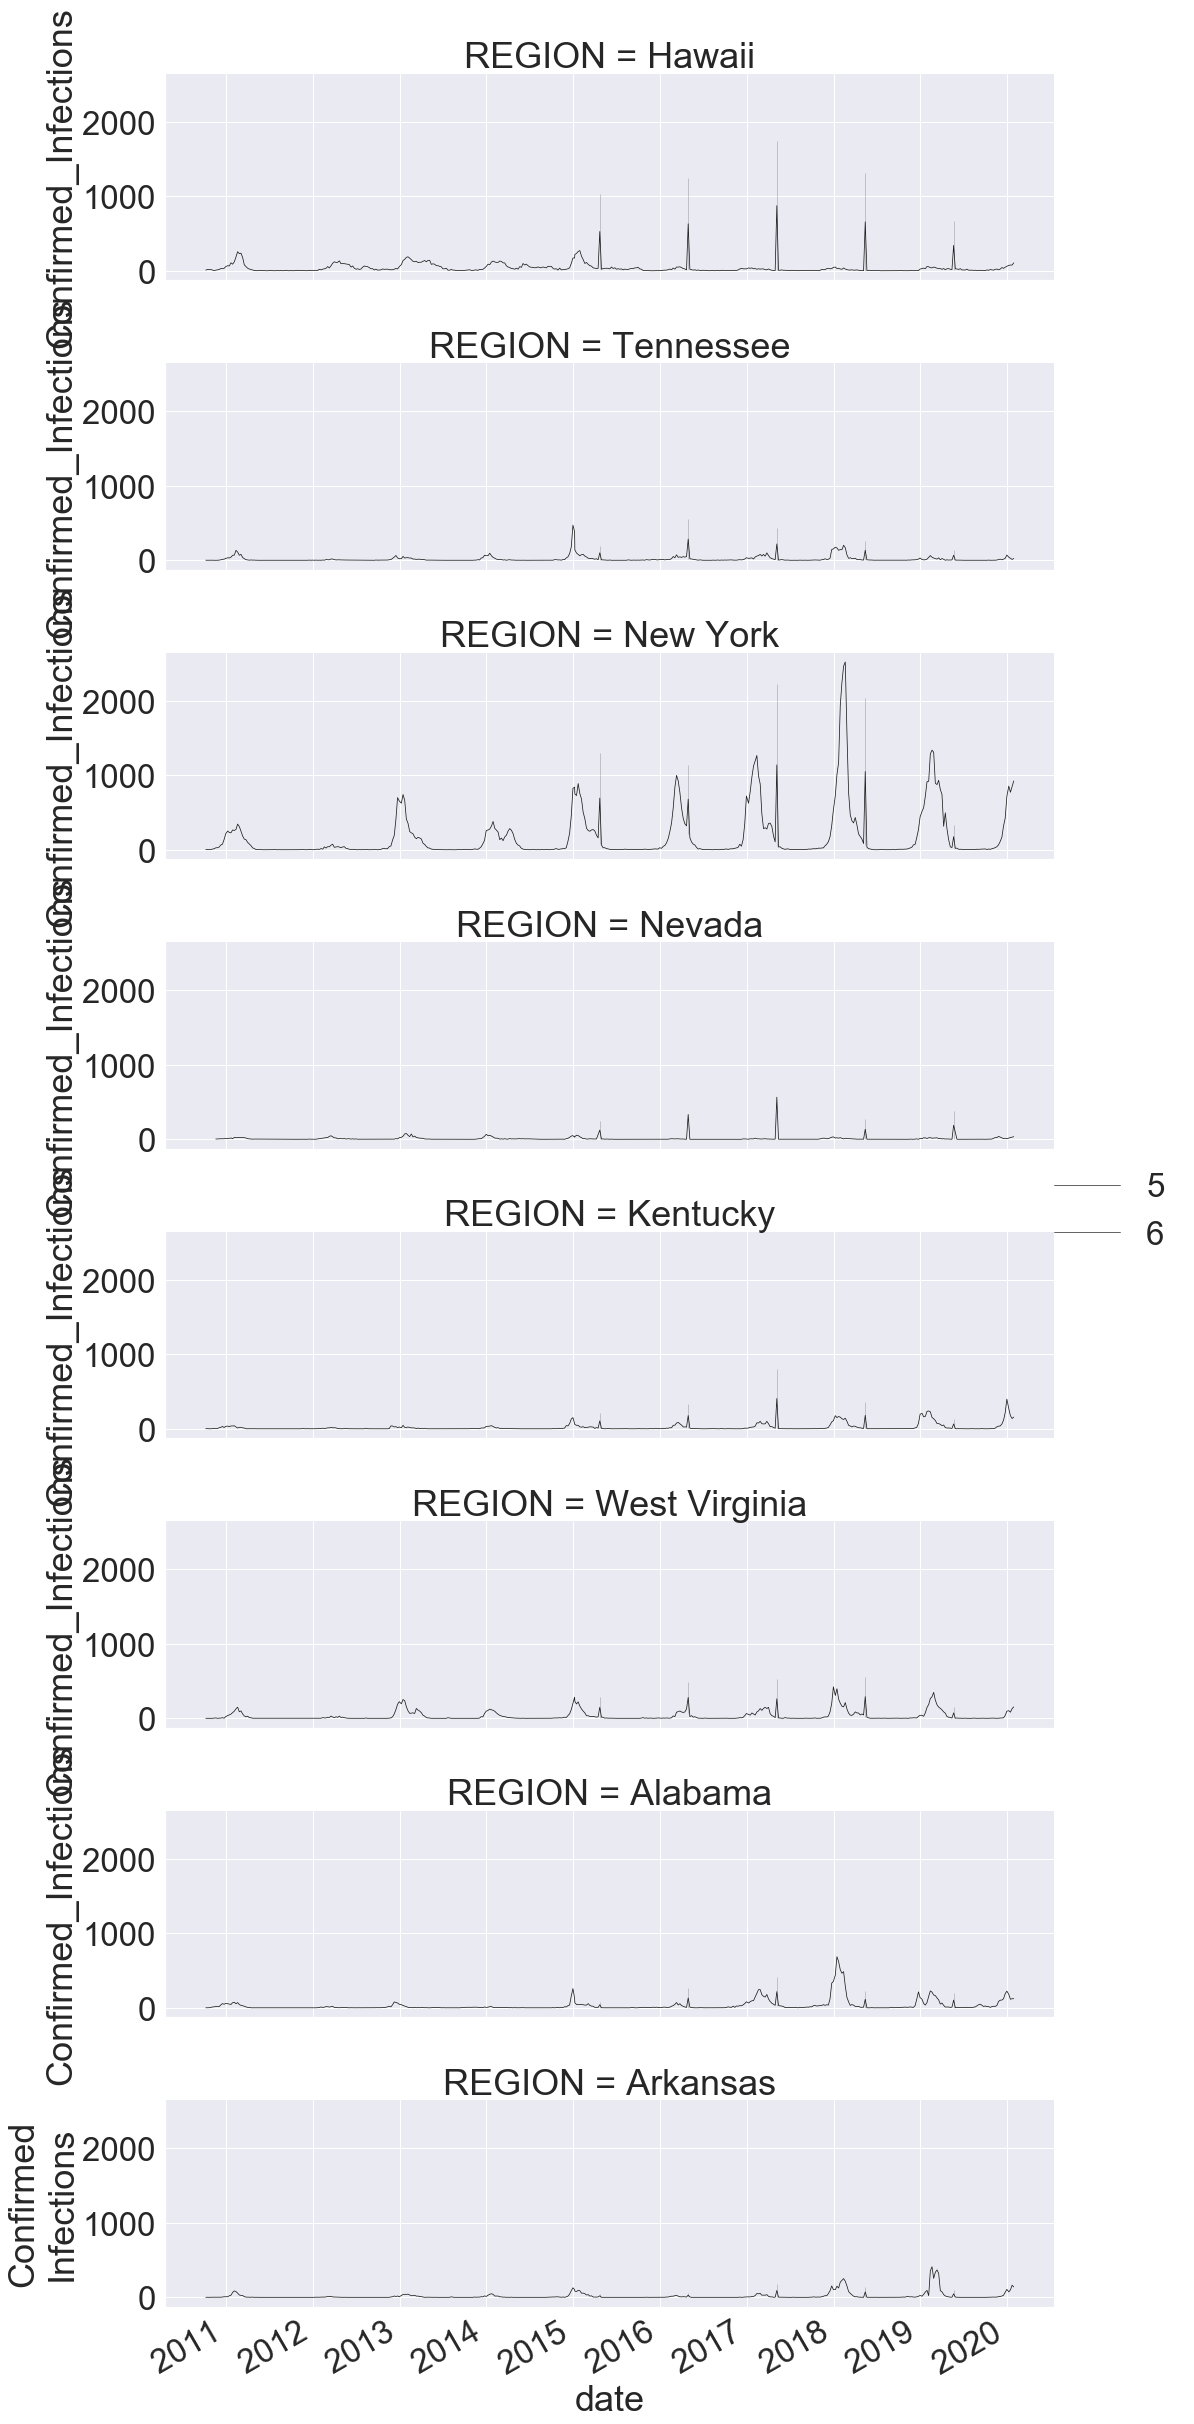

In [287]:
state_df= [ten_year_influenza_confirmed[masked] for masked in mask_list]
influenza_deadly_states = pd.concat(state_df)
import seaborn as sns

sns.set(font_scale=3)
g = sns.relplot(x="date", y="Confirmed_Infections",  kind="line", data=influenza_deadly_states, size=6, aspect=3,
                color ="k", row = "REGION") 
plt.ylabel("Confirmed\nInfections") 
               
g.fig.autofmt_xdate()

plt.plot()


#.figsize(15,8)